# CHAPTER 5 Text Summarization


## Text Normalization


In [1]:
from contractions import CONTRACTION_MAP
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from HTMLParser import HTMLParser
import unicodedata

stopword_list = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()
html_parser = HTMLParser()

def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
    
    
from pattern.en import tag
from nltk.corpus import wordnet as wn

# Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    
    tagged_text = tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text
    
# lemmatize text based on POS tags    
def lemmatize_text(text):
    
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text
    

def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    
    
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def unescape_html(parser, text):
    
    return parser.unescape(text)

def normalize_corpus(corpus, lemmatize=True, tokenize=False):
    
    normalized_corpus = []  
    for text in corpus:
        text = html_parser.unescape(text)
        text = expand_contractions(text, CONTRACTION_MAP)
        if lemmatize:
            text = lemmatize_text(text)
        else:
            text = text.lower()
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
            
    return normalized_corpus


def parse_document(document):
    document = re.sub('\n', ' ', document)
    if isinstance(document, str):
        document = document
    elif isinstance(document, unicode):
        return unicodedata.normalize('NFKD', document).encode('ascii', 'ignore')
    else:
        raise ValueError('Document is not string or unicode!')
    document = document.strip()
    sentences = nltk.sent_tokenize(document)
    sentences = [sentence.strip() for sentence in sentences]
    return sentences
    


## Keyphrase Extraction


### Collocations


In [2]:
from nltk.corpus import gutenberg
#from normalization import normalize_corpus
import nltk
from operator import itemgetter


In [3]:
alice = gutenberg.sents(fileids='carroll-alice.txt')
alice = [' '.join(ts) for ts in alice]
norm_alice = filter(None, normalize_corpus(alice, lemmatize=False))

# print first line
print norm_alice[0]


alice adventures wonderland lewis carroll 1865


In [4]:
def flatten_corpus(corpus):
    return ' '.join([document.strip() 
                     for document in corpus])
                         
def compute_ngrams(sequence, n):
    return zip(*[sequence[index:] 
                 for index in range(n)])


def get_top_ngrams(corpus, ngram_val=1, limit=5):

    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)

    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), 
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq) 
                     for text, freq in sorted_ngrams]

    return sorted_ngrams   
    


In [5]:
get_top_ngrams(corpus=norm_alice, ngram_val=2, limit=10)


[(u'said alice', 123),
 (u'mock turtle', 56),
 (u'march hare', 31),
 (u'said king', 29),
 (u'thought alice', 26),
 (u'said hatter', 22),
 (u'white rabbit', 22),
 (u'said mock', 20),
 (u'said gryphon', 18),
 (u'said caterpillar', 18)]

In [6]:
get_top_ngrams(corpus=norm_alice, ngram_val=3, limit=10)


[(u'said mock turtle', 20),
 (u'said march hare', 10),
 (u'poor little thing', 6),
 (u'white kid gloves', 5),
 (u'little golden key', 5),
 (u'march hare said', 5),
 (u'certainly said alice', 5),
 (u'mock turtle said', 5),
 (u'mouse mouse mouse', 4),
 (u'join dance join', 4)]

In [7]:
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

finder = BigramCollocationFinder.from_documents([item.split() 
                                                for item 
                                                in norm_alice])
bigram_measures = BigramAssocMeasures()                                                
finder.nbest(bigram_measures.raw_freq, 10)


[(u'said', u'alice'),
 (u'mock', u'turtle'),
 (u'march', u'hare'),
 (u'said', u'king'),
 (u'thought', u'alice'),
 (u'said', u'hatter'),
 (u'white', u'rabbit'),
 (u'said', u'mock'),
 (u'said', u'caterpillar'),
 (u'said', u'gryphon')]

In [8]:
finder.nbest(bigram_measures.pmi, 10)   


[(u'abide', u'figures'),
 (u'acceptance', u'elegant'),
 (u'accounting', u'tastes'),
 (u'accustomed', u'usurpation'),
 (u'act', u'crawling'),
 (u'adjourn', u'immediate'),
 (u'adoption', u'energetic'),
 (u'affair', u'trusts'),
 (u'agony', u'terror'),
 (u'alarmed', u'proposal')]

In [9]:
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures

finder = TrigramCollocationFinder.from_documents([item.split() 
                                                for item 
                                                in norm_alice])
trigram_measures = TrigramAssocMeasures()                                                
finder.nbest(trigram_measures.raw_freq, 10)


[(u'said', u'mock', u'turtle'),
 (u'said', u'march', u'hare'),
 (u'poor', u'little', u'thing'),
 (u'little', u'golden', u'key'),
 (u'march', u'hare', u'said'),
 (u'mock', u'turtle', u'said'),
 (u'white', u'kid', u'gloves'),
 (u'beau', u'ootiful', u'soo'),
 (u'certainly', u'said', u'alice'),
 (u'might', u'well', u'say')]

In [10]:
finder.nbest(trigram_measures.pmi, 10)  


[(u'accustomed', u'usurpation', u'conquest'),
 (u'adjourn', u'immediate', u'adoption'),
 (u'adoption', u'energetic', u'remedies'),
 (u'ancient', u'modern', u'seaography'),
 (u'apple', u'roast', u'turkey'),
 (u'arithmetic', u'ambition', u'distraction'),
 (u'brother', u'latin', u'grammar'),
 (u'canvas', u'bag', u'tied'),
 (u'cherry', u'tart', u'custard'),
 (u'circle', u'exact', u'shape')]

### Weighted Tag–Based Phrase Extraction


In [11]:
toy_text = """
Elephants are large mammals of the family Elephantidae 
and the order Proboscidea. Two species are traditionally recognised, 
the African elephant and the Asian elephant. Elephants are scattered 
throughout sub-Saharan Africa, South Asia, and Southeast Asia. Male 
African elephants are the largest extant terrestrial animals. All 
elephants have a long trunk used for many purposes, 
particularly breathing, lifting water and grasping objects. Their 
incisors grow into tusks, which can serve as weapons and as tools 
for moving objects and digging. Elephants' large ear flaps help 
to control their body temperature. Their pillar-like legs can 
carry their great weight. African elephants have larger ears 
and concave backs while Asian elephants have smaller ears 
and convex or level backs.  
"""


In [12]:
#from normalization import parse_document
import itertools
import nltk
#from normalization import stopword_list
from gensim import corpora, models



In [13]:
def get_chunks(sentences, grammar = r'NP: {<DT>? <JJ>* <NN.*>+}'):
    
    all_chunks = []
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    
    for sentence in sentences:
        
        tagged_sents = nltk.pos_tag_sents(
                            [nltk.word_tokenize(sentence)])
        
        chunks = [chunker.parse(tagged_sent) 
                  for tagged_sent in tagged_sents]
        
        wtc_sents = [nltk.chunk.tree2conlltags(chunk)
                     for chunk in chunks]    
         
        flattened_chunks = list(
                            itertools.chain.from_iterable(
                                wtc_sent for wtc_sent in wtc_sents)
                           )
        
        valid_chunks_tagged = [(status, [wtc for wtc in chunk]) 
                        for status, chunk 
                        in itertools.groupby(flattened_chunks, 
                                             lambda (word,pos,chunk): chunk != 'O')]
        
        valid_chunks = [' '.join(word.lower() 
                                for word, tag, chunk 
                                in wtc_group 
                                    if word.lower() 
                                        not in stopword_list) 
                                    for status, wtc_group 
                                    in valid_chunks_tagged
                                        if status]
                                            
        all_chunks.append(valid_chunks)
    
    return all_chunks
    
sentences = parse_document(toy_text)          
valid_chunks = get_chunks(sentences)
print valid_chunks


[['elephants', 'large mammals', 'family elephantidae', 'order proboscidea'], ['species', 'african elephant', 'asian elephant'], ['elephants', 'sub-saharan africa', 'south asia', 'southeast asia'], ['male african elephants', 'extant terrestrial animals'], ['elephants', 'long trunk', 'many purposes', 'breathing', 'water', 'grasping objects'], ['incisors', 'tusks', 'weapons', 'tools', 'objects', 'digging'], ['elephants', 'large ear flaps', 'body temperature'], ['pillar-like legs', 'great weight'], ['african elephants', 'ears', 'backs', 'asian elephants', 'ears', 'convex', 'level backs']]


In [14]:
def get_tfidf_weighted_keyphrases(sentences, 
                                  grammar=r'NP: {<DT>? <JJ>* <NN.*>+}',
                                  top_n=10):
    
    valid_chunks = get_chunks(sentences, grammar=grammar)
                                     
    dictionary = corpora.Dictionary(valid_chunks)
    corpus = [dictionary.doc2bow(chunk) for chunk in valid_chunks]
    
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    weighted_phrases = {dictionary.get(id): round(value,3) 
                        for doc in corpus_tfidf 
                        for id, value in doc}
                            
    weighted_phrases = sorted(weighted_phrases.items(), 
                              key=itemgetter(1), reverse=True)
    
    return weighted_phrases[:top_n]
    
get_tfidf_weighted_keyphrases(sentences, top_n=10)


[(u'pillar-like legs', 0.707),
 (u'male african elephants', 0.707),
 (u'great weight', 0.707),
 (u'extant terrestrial animals', 0.707),
 (u'large ear flaps', 0.684),
 (u'body temperature', 0.684),
 (u'ears', 0.667),
 (u'species', 0.577),
 (u'african elephant', 0.577),
 (u'asian elephant', 0.577)]

In [15]:
# try on other corpora!
get_tfidf_weighted_keyphrases(alice, top_n=10)
    


[(u'pardon', 1.0),
 (u'lory', 1.0),
 (u'piece round', 1.0),
 (u'pinch', 1.0),
 (u'dead silence', 1.0),
 (u'little sisters', 1.0),
 (u'changes', 1.0),
 (u'driest thing', 1.0),
 (u'another dead silence', 1.0),
 (u'narrow escape', 1.0)]

## Topic Modeling


In [16]:
from gensim import corpora, models
#from normalization import normalize_corpus
import numpy as np


In [17]:
toy_corpus = ["The fox jumps over the dog",
"The fox is very clever and quick",
"The dog is slow and lazy",
"The cat is smarter than the fox and the dog",
"Python is an excellent programming language",
"Java and Ruby are other programming languages",
"Python and Java are very popular programming languages",
"Python programs are smaller than Java programs"]


### Latent Semantic Indexing


In [18]:
# LSI topic model
norm_tokenized_corpus = normalize_corpus(toy_corpus, tokenize=True)
norm_tokenized_corpus


[[u'fox', u'jump', u'dog'],
 [u'fox', u'clever', u'quick'],
 [u'dog', u'slow', u'lazy'],
 [u'cat', u'smarter', u'fox', u'dog'],
 [u'python', u'excellent', u'programming', u'language'],
 [u'java', u'ruby', u'programming', u'language'],
 [u'python', u'java', u'popular', u'programming', u'language'],
 [u'python', u'program', u'small', u'java', u'program']]

In [19]:
dictionary = corpora.Dictionary(norm_tokenized_corpus)
print dictionary.token2id


{u'program': 17, u'lazy': 5, u'clever': 4, u'java': 13, u'programming': 10, u'language': 11, u'python': 9, u'smarter': 7, u'fox': 1, u'dog': 2, u'cat': 8, u'jump': 0, u'popular': 15, u'slow': 6, u'excellent': 12, u'quick': 3, u'small': 16, u'ruby': 14}


In [20]:
corpus = [dictionary.doc2bow(text) for text in norm_tokenized_corpus]
corpus


[[(0, 1), (1, 1), (2, 1)],
 [(1, 1), (3, 1), (4, 1)],
 [(2, 1), (5, 1), (6, 1)],
 [(1, 1), (2, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1)],
 [(10, 1), (11, 1), (13, 1), (14, 1)],
 [(9, 1), (10, 1), (11, 1), (13, 1), (15, 1)],
 [(9, 1), (13, 1), (16, 1), (17, 2)]]

In [21]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

total_topics = 2

lsi = models.LsiModel(corpus_tfidf, 
                      id2word=dictionary, 
                      num_topics=total_topics)
                      
for index, topic in lsi.print_topics(total_topics):
    print 'Topic #'+str(index+1)
    print topic
    print              


Topic #1
0.459*"programming" + 0.459*"language" + 0.344*"java" + 0.344*"python" + 0.336*"popular" + 0.318*"ruby" + 0.318*"excellent" + 0.148*"program" + 0.074*"small" + -0.000*"jump"

Topic #2
0.459*"dog" + 0.459*"fox" + 0.444*"jump" + 0.322*"cat" + 0.322*"smarter" + 0.208*"slow" + 0.208*"lazy" + 0.208*"quick" + 0.208*"clever" + 0.000*"program"



In [22]:
def print_topics_gensim(topic_model, total_topics=1,
                        weight_threshold=0.0001,
                        display_weights=False,
                        num_terms=None):
    
    for index in range(total_topics):
        topic = topic_model.show_topic(index)
        topic = [(word, round(wt,2)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
        if display_weights:
            print 'Topic #'+str(index+1)+' with weights'
            print topic[:num_terms] if num_terms else topic
        else:
            print 'Topic #'+str(index+1)+' without weights'
            tw = [term for term, wt in topic]
            print tw[:num_terms] if num_terms else tw
        print


In [23]:
print_topics_gensim(topic_model=lsi,
                    total_topics=total_topics,
                    num_terms=5,
                    display_weights=True)


Topic #1 with weights
[(u'programming', 0.46), (u'language', 0.46), (u'java', 0.34), (u'python', 0.34), (u'popular', 0.34)]

Topic #2 with weights
[(u'dog', 0.46), (u'fox', 0.46), (u'jump', 0.44), (u'cat', 0.32), (u'smarter', 0.32)]



In [24]:
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) 
                           for row 
                           in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) 
                               for wt, index 
                               in zip(weights,sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) 
                             for row 
                             in sorted_indices])
    
    topics = [np.vstack((terms.T, 
                     term_weights.T)).T 
              for terms, term_weights 
              in zip(sorted_terms, sorted_weights)]     
    
    return topics            
  
                       
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        topic = [(word, round(wt,2)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
                     
        if display_weights:
            print 'Topic #'+str(index+1)+' with weights'
            print topic[:num_terms] if num_terms else topic
        else:
            print 'Topic #'+str(index+1)+' without weights'
            tw = [term for term, wt in topic]
            print tw[:num_terms] if num_terms else tw
        print


In [25]:
# LSI custom built topic model    
from utils import build_feature_matrix, low_rank_svd

norm_corpus = normalize_corpus(toy_corpus)

vectorizer, tfidf_matrix = build_feature_matrix(norm_corpus, 
                                    feature_type='tfidf')
td_matrix = tfidf_matrix.transpose()
                              
td_matrix = td_matrix.multiply(td_matrix > 0)

total_topics = 2
feature_names = vectorizer.get_feature_names()

u, s, vt = low_rank_svd(td_matrix, singular_count=total_topics)
weights = u.transpose() * s[:, None]


In [26]:
topics = get_topics_terms_weights(weights, feature_names)        
print_topics_udf(topics=topics,
                 total_topics=total_topics,
                 weight_threshold=0.15,
                 display_weights=False)


Topic #1 without weights
[u'dog', u'fox', u'jump', u'smarter', u'cat', u'slow', u'lazy', u'quick', u'clever']

Topic #2 without weights
[u'programming', u'language', u'java', u'python', u'popular', u'ruby', u'excellent', u'program']



In [27]:
def train_lsi_model_gensim(corpus, total_topics=2):
    
    norm_tokenized_corpus = normalize_corpus(corpus, tokenize=True)
    dictionary = corpora.Dictionary(norm_tokenized_corpus)
    mapped_corpus = [dictionary.doc2bow(text) 
                     for text in norm_tokenized_corpus]
    tfidf = models.TfidfModel(mapped_corpus)
    corpus_tfidf = tfidf[mapped_corpus]
    lsi = models.LsiModel(corpus_tfidf, 
                          id2word=dictionary,
                          num_topics=total_topics)
    return lsi
 





### Latent Dirichlet Allocation


In [28]:

def train_lda_model_gensim(corpus, total_topics=2):
    
    norm_tokenized_corpus = normalize_corpus(corpus, tokenize=True)
    dictionary = corpora.Dictionary(norm_tokenized_corpus)
    mapped_corpus = [dictionary.doc2bow(text) 
                     for text in norm_tokenized_corpus]
    tfidf = models.TfidfModel(mapped_corpus)
    corpus_tfidf = tfidf[mapped_corpus]
    lda = models.LdaModel(corpus_tfidf, 
                          id2word=dictionary,
                          iterations=1000,
                          num_topics=total_topics)
    return lda                     


In [29]:
lda_gensim = train_lda_model_gensim(toy_corpus,
                                    total_topics=2)
                                    
print_topics_gensim(topic_model=lda_gensim,
                    total_topics=2,
                    num_terms=5,
                    display_weights=True)                                    


Topic #1 with weights
[(u'dog', 0.07), (u'fox', 0.07), (u'ruby', 0.07), (u'jump', 0.07), (u'slow', 0.06)]

Topic #2 with weights
[(u'program', 0.08), (u'python', 0.08), (u'excellent', 0.07), (u'programming', 0.07), (u'language', 0.07)]



In [30]:
from sklearn.decomposition import LatentDirichletAllocation

norm_corpus = normalize_corpus(toy_corpus)
vectorizer, tfidf_matrix = build_feature_matrix(norm_corpus, 
                                    feature_type='tfidf')                     
total_topics = 2
lda = LatentDirichletAllocation(n_topics=total_topics, 
                                max_iter=1000,
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=42)
lda.fit(tfidf_matrix)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=1000, mean_change_tol=0.001,
             n_jobs=1, n_topics=2, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [31]:
feature_names = vectorizer.get_feature_names()
weights = lda.components_

topics = get_topics_terms_weights(weights, feature_names)
print_topics_udf(topics=topics,
                 total_topics=total_topics,
                 num_terms=8,
                 display_weights=True)


Topic #1 with weights
[(u'fox', 1.86), (u'dog', 1.86), (u'jump', 1.19), (u'clever', 1.12), (u'quick', 1.12), (u'lazy', 1.12), (u'slow', 1.12), (u'cat', 1.06)]

Topic #2 with weights
[(u'programming', 1.8), (u'language', 1.8), (u'java', 1.64), (u'python', 1.64), (u'program', 1.3), (u'ruby', 1.11), (u'excellent', 1.11), (u'popular', 1.06)]



### Non-negative Matrix Factorization


In [32]:
from sklearn.decomposition import NMF

norm_corpus = normalize_corpus(toy_corpus)
vectorizer, tfidf_matrix = build_feature_matrix(norm_corpus, 
                                    feature_type='tfidf')                     
total_topics = 2
nmf = NMF(n_components=total_topics, 
          random_state=42, alpha=.1, l1_ratio=.5)
nmf.fit(tfidf_matrix)      


NMF(alpha=0.1, beta=1, eta=0.1, init=None, l1_ratio=0.5, max_iter=200,
  n_components=2, nls_max_iter=2000, random_state=42, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [33]:
feature_names = vectorizer.get_feature_names()
weights = nmf.components_

topics = get_topics_terms_weights(weights, feature_names)
print_topics_udf(topics=topics,
                 total_topics=total_topics,
                 num_terms=None,
                 display_weights=True)   


Topic #1 with weights
[(u'programming', 0.55), (u'language', 0.55), (u'python', 0.4), (u'java', 0.4), (u'popular', 0.24), (u'ruby', 0.23), (u'excellent', 0.23), (u'program', 0.09), (u'small', 0.03)]

Topic #2 with weights
[(u'dog', 0.57), (u'fox', 0.57), (u'jump', 0.35), (u'smarter', 0.26), (u'cat', 0.26), (u'quick', 0.13), (u'slow', 0.13), (u'clever', 0.13), (u'lazy', 0.13)]



### Extracting Topics from Product Reviews


In [34]:
import pandas as pd
import numpy as np 
                 
CORPUS = pd.read_csv('amazon_skyrim_reviews.csv')                     
CORPUS = np.array(CORPUS['Reviews'])


In [35]:
# view sample review
print CORPUS[12]


I base the value of a game on the amount of enjoyable gameplay I can get out of it and this one was definitely worth the price!


In [36]:
total_topics = 5
        
lsi_gensim = train_lsi_model_gensim(CORPUS,
                                    total_topics=total_topics)
print_topics_gensim(topic_model=lsi_gensim,
                    total_topics=total_topics,
                    num_terms=10,
                    display_weights=False) 


Topic #1 without weights
[u'skyrim', u'one', u'quest', u'like', u'play', u'oblivion', u'go', u'get', u'time', u'level']

Topic #2 without weights
[u'recommend', u'love', u'ever', u'best', u'great', u'level', u'highly', u'play', u'elder', u'scroll']

Topic #3 without weights
[u'recommend', u'fun', u'highly', u'love', u'ever', u'wonderful', u'scroll', u'series', u'best', u'elder']

Topic #4 without weights
[u'fun', u'scroll', u'elder', u'recommend', u'highly', u'wonderful', u'series', u'cool', u'graphic', u'best']

Topic #5 without weights
[u'fun', u'love', u'scroll', u'elder', u'highly', u'5', u'dont', u'gameplay', u'hundred', u'hour']



In [37]:
lda_gensim = train_lda_model_gensim(CORPUS,
                                    total_topics=total_topics)
print_topics_gensim(topic_model=lda_gensim,
                    total_topics=total_topics,
                    num_terms=10,
                    display_weights=False) 


Topic #1 without weights
[u'skyrim', u'much', u'quest', u'buy', u'time', u'hour', u'enjoy', u'get', u'world', u'best']

Topic #2 without weights
[u'long', u'buy', u'amazing', u'play', u'great', u'time', u'love', u'one', u'really', u'save']

Topic #3 without weights
[u'love', u'play', u'best', u'one', u'elder', u'scroll', u'like', u'get', u'still', u'oblivion']

Topic #4 without weights
[u'skyrim', u'oblivion', u'play', u'good', u'quest', u'like', u'time', u'level', u'one', u'want']

Topic #5 without weights
[u'great', u'fun', u'love', u'get', u'play', u'hour', u'one', u'good', u'ever', u'graphic']



In [38]:
norm_corpus = normalize_corpus(CORPUS)
vectorizer, tfidf_matrix = build_feature_matrix(norm_corpus, 
                                    feature_type='tfidf') 
feature_names = vectorizer.get_feature_names()


lda = LatentDirichletAllocation(n_topics=total_topics, 
                                max_iter=1000,
                                learning_method='online', 
                                learning_offset=10.,
                                random_state=42)


In [39]:
lda.fit(tfidf_matrix)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=1000, mean_change_tol=0.001,
             n_jobs=1, n_topics=5, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [40]:
weights = lda.components_
topics = get_topics_terms_weights(weights, feature_names)
print_topics_udf(topics=topics,
                 total_topics=total_topics,
                 num_terms=10,
                 display_weights=False)


Topic #1 without weights
[u'estatic', u'booklet', u'wonder4ful', u'electricity', u'heat', u'trhats', u'amazingly', u'interfere', u'chirstmas', u'12yr']

Topic #2 without weights
[u'game', u'play', u'get', u'one', u'skyrim', u'great', u'like', u'time', u'quest', u'much']

Topic #3 without weights
[u'de', u'pagar', u'cr\xe9dito', u'momento', u'compras', u'responsabilidad', u'para', u'recomiendo', u'futuras', u'skyrimseguridad']

Topic #4 without weights
[u'booklet', u'estatic', u'wonder4ful', u'electricity', u'heat', u'trhats', u'amazingly', u'interfere', u'chirstmas', u'12yr']

Topic #5 without weights
[u'estatic', u'booklet', u'wonder4ful', u'electricity', u'trhats', u'heat', u'amazingly', u'interfere', u'chirstmas', u'12yr']



In [41]:
nmf = NMF(n_components=total_topics, 
          random_state=42, alpha=.1, l1_ratio=.5)
nmf.fit(tfidf_matrix)      


NMF(alpha=0.1, beta=1, eta=0.1, init=None, l1_ratio=0.5, max_iter=200,
  n_components=5, nls_max_iter=2000, random_state=42, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [42]:
feature_names = vectorizer.get_feature_names()
weights = nmf.components_

topics = get_topics_terms_weights(weights, feature_names)
print_topics_udf(topics=topics,
                 total_topics=total_topics,
                 num_terms=10,
                 display_weights=False)                                       

Topic #1 without weights
[u'game', u'get', u'skyrim', u'play', u'time', u'like', u'quest', u'one', u'go', u'much']

Topic #2 without weights
[u'game', u'best', u'ever', u'fun', u'play', u'hour', u'great', u'rpg', u'definitely', u'one']

Topic #3 without weights
[u'write', u'review', u'describe', u'justice', u'word', u'game', u'simply', u'try', u'period', u'really']

Topic #4 without weights
[u'scroll', u'elder', u'series', u'always', u'love', u'pass', u'buy', u'franchise', u'game', u'best']

Topic #5 without weights
[u'recommend', u'love', u'game', u'highly', u'great', u'play', u'wonderful', u'like', u'oblivion', u'would']



## Automated Document Summarization


In [43]:
#from normalization import normalize_corpus, parse_document
from utils import build_feature_matrix, low_rank_svd
import numpy as np


In [44]:
toy_text = """
Elephants are large mammals of the family Elephantidae 
and the order Proboscidea. Two species are traditionally recognised, 
the African elephant and the Asian elephant. Elephants are scattered 
throughout sub-Saharan Africa, South Asia, and Southeast Asia. Male 
African elephants are the largest extant terrestrial animals. All 
elephants have a long trunk used for many purposes, 
particularly breathing, lifting water and grasping objects. Their 
incisors grow into tusks, which can serve as weapons and as tools 
for moving objects and digging. Elephants' large ear flaps help 
to control their body temperature. Their pillar-like legs can 
carry their great weight. African elephants have larger ears 
and concave backs while Asian elephants have smaller ears 
and convex or level backs.  
"""


In [45]:
from gensim.summarization import summarize, keywords

def text_summarization_gensim(text, summary_ratio=0.5):
    
    summary = summarize(text, split=True, ratio=summary_ratio)
    for sentence in summary:
        print sentence

docs = parse_document(toy_text)
text = ' '.join(docs)
text_summarization_gensim(text, summary_ratio=0.4)


Two species are traditionally recognised,  the African elephant and the Asian elephant.
All  elephants have a long trunk used for many purposes,  particularly breathing, lifting water and grasping objects.
African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.


In [46]:
sentences = parse_document(toy_text)
norm_sentences = normalize_corpus(sentences,lemmatize=False) 

total_sentences = len(norm_sentences)
print 'Total Sentences in Document:', total_sentences   


Total Sentences in Document: 9


### Latent Semantic Analysis


In [47]:
num_sentences = 3
num_topics = 2

vec, dt_matrix = build_feature_matrix(sentences, 
                                      feature_type='frequency')

td_matrix = dt_matrix.transpose()
td_matrix = td_matrix.multiply(td_matrix > 0)

u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)  
                                         
sv_threshold = 0.5
min_sigma_value = max(s) * sv_threshold
s[s < min_sigma_value] = 0

salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))
print np.round(salience_scores, 2)


[ 2.02  2.07  1.53  1.4   2.1   4.48  0.7   1.2   4.65]


In [48]:
top_sentence_indices = salience_scores.argsort()[-num_sentences:][::-1]
top_sentence_indices.sort()
print top_sentence_indices


[4 5 8]


In [49]:
for index in top_sentence_indices:
    print sentences[index]


All  elephants have a long trunk used for many purposes,  particularly breathing, lifting water and grasping objects.
Their  incisors grow into tusks, which can serve as weapons and as tools  for moving objects and digging.
African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.


In [50]:
def lsa_text_summarizer(documents, num_sentences=2,
                        num_topics=2, feature_type='frequency',
                        sv_threshold=0.5):
                            
    vec, dt_matrix = build_feature_matrix(documents, 
                                          feature_type=feature_type)

    td_matrix = dt_matrix.transpose()
    td_matrix = td_matrix.multiply(td_matrix > 0)

    u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)  
    min_sigma_value = max(s) * sv_threshold
    s[s < min_sigma_value] = 0
    
    salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))
    top_sentence_indices = salience_scores.argsort()[-num_sentences:][::-1]
    top_sentence_indices.sort()
    
    for index in top_sentence_indices:
        print sentences[index]


### TextRank


In [51]:
import networkx


In [52]:
num_sentences = 3
vec, dt_matrix = build_feature_matrix(norm_sentences, 
                                      feature_type='tfidf')
similarity_matrix = (dt_matrix * dt_matrix.T)
print np.round(similarity_matrix.todense(), 2)


[[ 1.    0.    0.03  0.05  0.03  0.    0.15  0.    0.06]
 [ 0.    1.    0.    0.07  0.    0.    0.    0.    0.11]
 [ 0.03  0.    1.    0.03  0.02  0.    0.03  0.    0.04]
 [ 0.05  0.07  0.03  1.    0.03  0.    0.04  0.    0.11]
 [ 0.03  0.    0.02  0.03  1.    0.07  0.03  0.    0.04]
 [ 0.    0.    0.    0.    0.07  1.    0.    0.    0.  ]
 [ 0.15  0.    0.03  0.04  0.03  0.    1.    0.    0.05]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.06  0.11  0.04  0.11  0.04  0.    0.05  0.    1.  ]]


In [53]:
similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix)


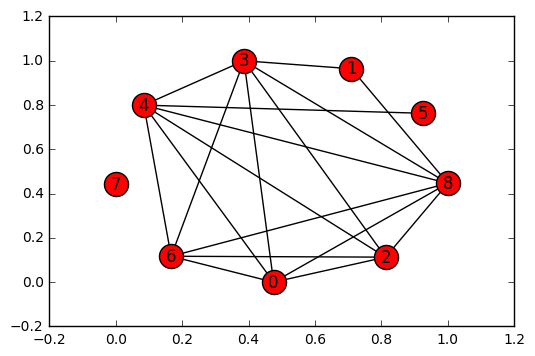

In [54]:
import matplotlib.pyplot as plt
networkx.draw_networkx(similarity_graph)
plt.show()

In [55]:
scores = networkx.pagerank(similarity_graph)

ranked_sentences = sorted(((score, index) 
                            for index, score 
                            in scores.items()), 
                          reverse=True)
ranked_sentences


[(0.11889477617125277, 8),
 (0.11456045476451866, 3),
 (0.11285293843138654, 0),
 (0.11210156056437962, 6),
 (0.11139550507847462, 4),
 (0.1111111111111111, 7),
 (0.10709498606197024, 5),
 (0.10610242758495998, 2),
 (0.10588624023194664, 1)]

In [56]:
top_sentence_indices = [ranked_sentences[index][1] 
                        for index in range(num_sentences)]
top_sentence_indices.sort()
print top_sentence_indices


[0, 3, 8]


In [57]:
for index in top_sentence_indices:
    print sentences[index]
    


Elephants are large mammals of the family Elephantidae  and the order Proboscidea.
Male  African elephants are the largest extant terrestrial animals.
African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.


In [58]:
def textrank_text_summarizer(documents, num_sentences=2,
                             feature_type='frequency'):
    
    vec, dt_matrix = build_feature_matrix(norm_sentences, 
                                      feature_type='tfidf')
    similarity_matrix = (dt_matrix * dt_matrix.T)
        
    similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix)
    scores = networkx.pagerank(similarity_graph)   
    
    ranked_sentences = sorted(((score, index) 
                                for index, score 
                                in scores.items()), 
                              reverse=True)

    top_sentence_indices = [ranked_sentences[index][1] 
                            for index in range(num_sentences)]
    top_sentence_indices.sort()
    
    for index in top_sentence_indices:
        print sentences[index]                             


### Summarizing a Product Description


In [59]:
DOCUMENT = """
The Elder Scrolls V: Skyrim is an open world action role-playing video game 
developed by Bethesda Game Studios and published by Bethesda Softworks. 
It is the fifth installment in The Elder Scrolls series, following 
The Elder Scrolls IV: Oblivion. Skyrim's main story revolves around 
the player character and their effort to defeat Alduin the World-Eater, 
a dragon who is prophesied to destroy the world. 
The game is set two hundred years after the events of Oblivion 
and takes place in the fictional province of Skyrim. The player completes quests 
and develops the character by improving skills. 
Skyrim continues the open world tradition of its predecessors by allowing the 
player to travel anywhere in the game world at any time, and to 
ignore or postpone the main storyline indefinitely. The player may freely roam 
over the land of Skyrim, which is an open world environment consisting 
of wilderness expanses, dungeons, cities, towns, fortresses and villages. 
Players may navigate the game world more quickly by riding horses, 
or by utilizing a fast-travel system which allows them to warp to previously 
Players have the option to develop their character. At the beginning of the game, 
players create their character by selecting one of several races, 
including humans, orcs, elves and anthropomorphic cat or lizard-like creatures, 
and then customizing their character's appearance.discovered locations. Over the 
course of the game, players improve their character's skills, which are numerical 
representations of their ability in certain areas. There are eighteen skills 
divided evenly among the three schools of combat, magic, and stealth. 
Skyrim is the first entry in The Elder Scrolls to include Dragons in the game's 
wilderness. Like other creatures, Dragons are generated randomly in the world 
and will engage in combat. 
"""


In [60]:
sentences = parse_document(DOCUMENT)
norm_sentences = normalize_corpus(sentences,lemmatize=True) 
print "Total Sentences:", len(norm_sentences) 


Total Sentences: 13


In [61]:
lsa_text_summarizer(norm_sentences, num_sentences=3,
                    num_topics=5, feature_type='frequency',
                    sv_threshold=0.5)  


The Elder Scrolls V: Skyrim is an open world action role-playing video game  developed by Bethesda Game Studios and published by Bethesda Softworks.
Players may navigate the game world more quickly by riding horses,  or by utilizing a fast-travel system which allows them to warp to previously  Players have the option to develop their character.
At the beginning of the game,  players create their character by selecting one of several races,  including humans, orcs, elves and anthropomorphic cat or lizard-like creatures,  and then customizing their character's appearance.discovered locations.


In [62]:
textrank_text_summarizer(norm_sentences, num_sentences=3,
                         feature_type='tfidf')                                        

The Elder Scrolls V: Skyrim is an open world action role-playing video game  developed by Bethesda Game Studios and published by Bethesda Softworks.
Players may navigate the game world more quickly by riding horses,  or by utilizing a fast-travel system which allows them to warp to previously  Players have the option to develop their character.
Skyrim is the first entry in The Elder Scrolls to include Dragons in the game's  wilderness.
